In [1]:
import mynn
from mynn.layers.dense import dense
from mynn.optimizers.sgd import SGD
from mygrad.nnet.losses.margin_ranking_loss import margin_ranking_loss
import mygrad as mg
from noggin import create_plot
import numpy as np
import pickle
from mygrad.nnet.initializers import glorot_normal
from coco_class import Coco
from generate_triplets import generate_triplets
%matplotlib notebook

In [15]:
class Img2Caption:
    def __init__(self, dim_input: int, dim_output: int):
        """
        Initializes the Img2Caption Linear Encoder
        Parameters
        ----------
        dim_input the dimensions of the input descriptor
        dim_output the dimensions of the encoded value
        """
        self.layer = dense(dim_input, dim_output, weight_initializer=glorot_normal)
        
    def __call__(self, descriptor):
        """
        Runs the forward pass of the model
        Parameters
        ----------
        descriptor the descriptor vector to be processed

        Returns
        -------
        The shape-(dim_output) embedding

        """
        result = self.layer(descriptor)
        magnitude = mg.sqrt(mg.sum(mg.square(result), axis = 1, keepdims=True))
        return result / magnitude
    
    @property
    def parameters(self):
        """
        Returns the parameters of the encoding layer
        Returns
        -------
        The parameters of the encoding layer
        """
        return self.layer.parameters

In [3]:
with open("coco_db.pkl", mode="rb") as file:
    data = pickle.load(file)

In [4]:
train, validation = generate_triplets(data)

6609
0
1000
2000
3000
4000
5000
6000
1653
0
1000


ValueError: cannot reshape array of size 50 into shape (512,)

In [11]:
with open("train_triplets_v1.pkl", mode="rb") as file:
    train = pickle.load(file)
    


In [19]:
model = Img2Caption(512, 50)
lr = 1e-3
momentum = 0.9
optim = SGD(model.parameters, learning_rate = lr, momentum = momentum)


<IPython.core.display.Javascript object>


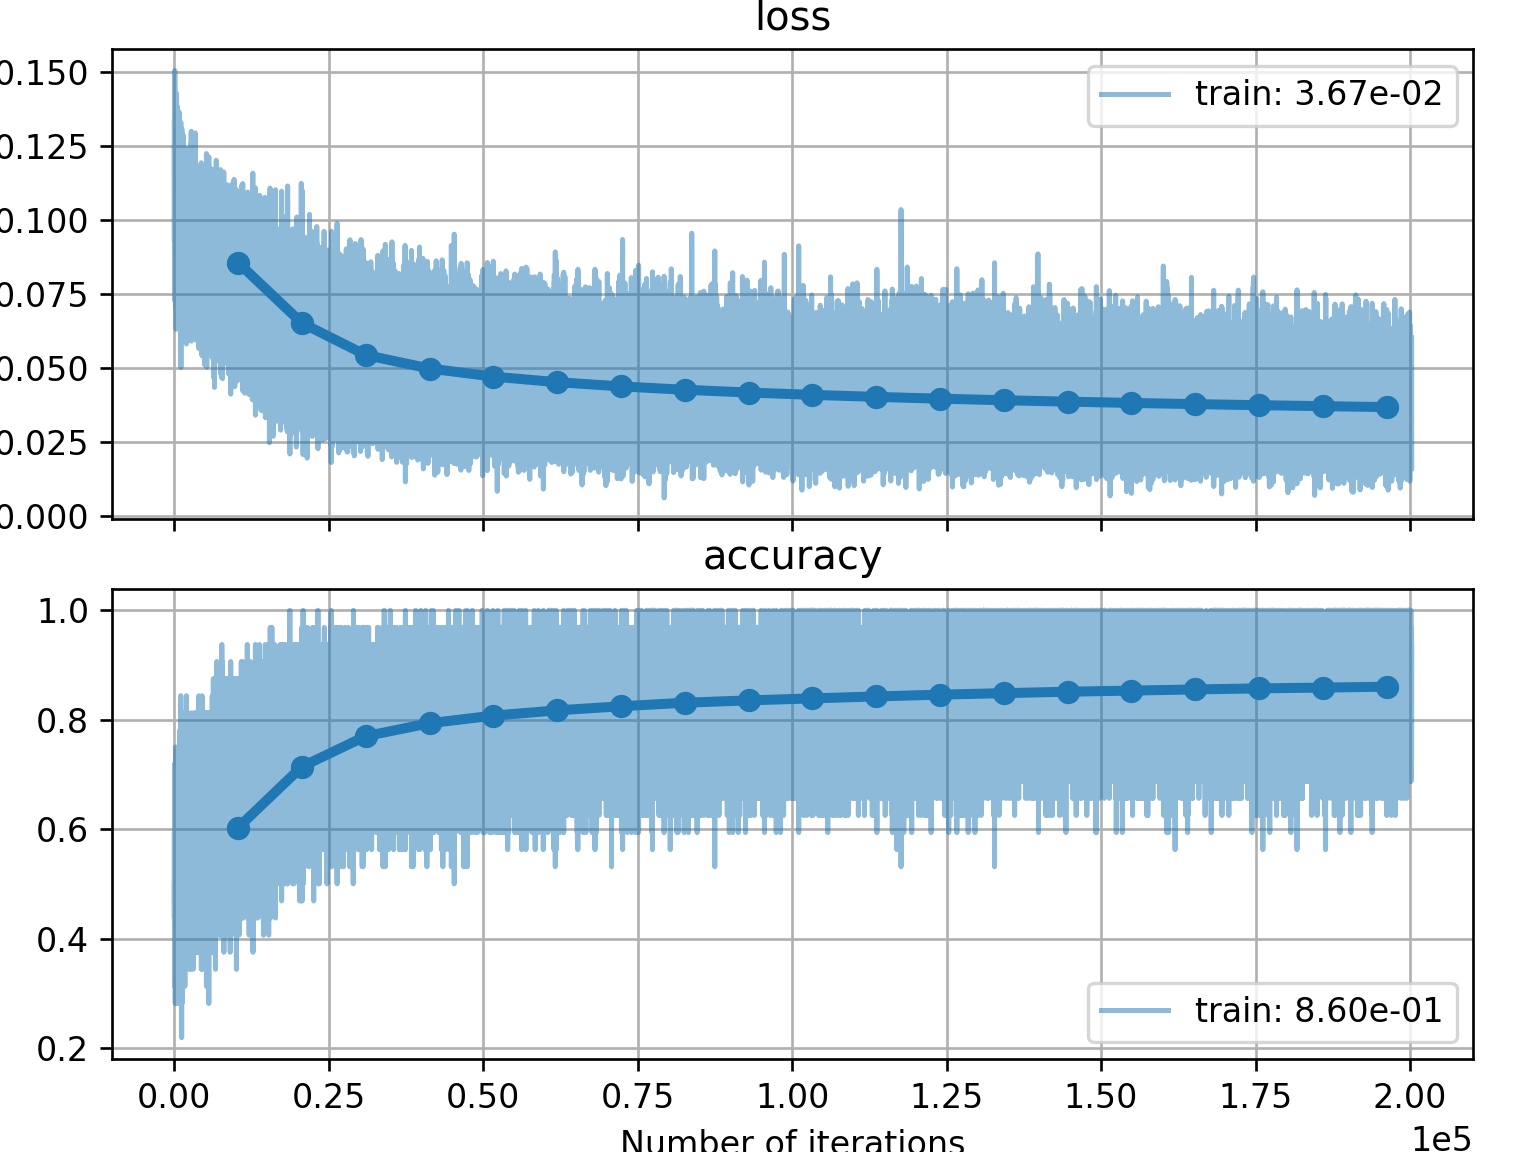

In [20]:
plotter, figs, axes = create_plot(metrics=["loss", "accuracy"])

In [29]:
epochs = 20
batch_size = 32

d_img = train[0]
w_good = train[1]
w_good = w_good / np.linalg.norm(w_good, axis=1, keepdims=True)
d_bad = train[2]
for ep in range(epochs):
    idx = np.arange(len(train[0]))
    np.random.shuffle(idx)
    for batch_cnt in range(len(train[0]) // batch_size + 1):
        b = idx[batch_cnt * batch_size:(batch_cnt + 1) * batch_size]
        
        bd_img = d_img[b]
        bw_good = w_good[b]
        bd_bad = d_bad[b]
        
        w_bad = model(bd_bad) # Shape (32, 50)
        w_img = model(bd_img) # Shape (32, 50)
        
        dot_good = mg.sum(w_img * bw_good, axis=1) # Shape (32,)
            
        dot_bad = mg.sum(bw_good * w_bad, axis=1) # Shape (32,)
        acc = np.mean(dot_good > dot_bad)
        
        loss = margin_ranking_loss(dot_good, dot_bad, 1, margin=0.1)

        loss.backward()

        optim.step()

        loss.null_gradients()

        plotter.set_train_batch(metrics={"loss": loss.item(), "accuracy":acc}, batch_size=batch_size)

    plotter.set_train_epoch()


In [22]:
def save_model(self, path):
    """Path to .npz file where model parameters will be saved."""
    with open(path, "wb") as f:
        np.savez(f, *(x.data for x in self.parameters))

def load_model(self, path):
    with open(path, "rb") as f:
        for param, (name, array) in zip(self.parameters, np.load(f).items()):
            param.data[:] = array

In [30]:
save_model(model, "model_twenty_epochs.npz")